# Analysis of Audience participant body sway, MusicLab Copenhagen


Generation of plots for Audience Motion paper

In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

import matplotlib.gridspec as gridspec

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [3]:
%reload_ext autoreload

In [4]:
# https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [5]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [6]:
internal_Part = general_loc + 'Participants_internal/'

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [8]:
# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


In [9]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [10]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [11]:
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
104.73979234695435
104.80955219268799


In [12]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts.iloc[:5,:]

,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


In [13]:
aud_df.index = (ts_ct/1000).round(1)
ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1) # convert to seconds from milliseconds


In [14]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')

# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(aligned_Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(aligned_Part_Codes),:].reset_index(drop = True)

In [15]:
#aligned_Part_Codes[:85], aligned_Part_Codes[85:]
AUD = aud_df.loc[:,aligned_Part_Codes[:85]].copy()
AUD['Virtual'] = np.nan
AUD['Virtual.'] = np.nan
AUD['Virtual..'] = np.nan
AUD['Virtual...'] = np.nan
AUD['Virtual....'] = np.nan
AUD = pd.concat([AUD,aud_df.loc[:,aligned_Part_Codes[85:]].copy()],axis=1)

In [16]:
concert_times.iloc[52,:]

Datetime          2021-10-26 20:16:49
Time_s                        8922.88
Time_ms                       8922880
Event                  Return sensors
Event_Type                        End
Time_Stream                  10560.12
Event_Duration                    0.0
Shorter_tag                  Disperse
sequence                           52
Name: 52, dtype: object

[-691.24, 8352.060000000001]


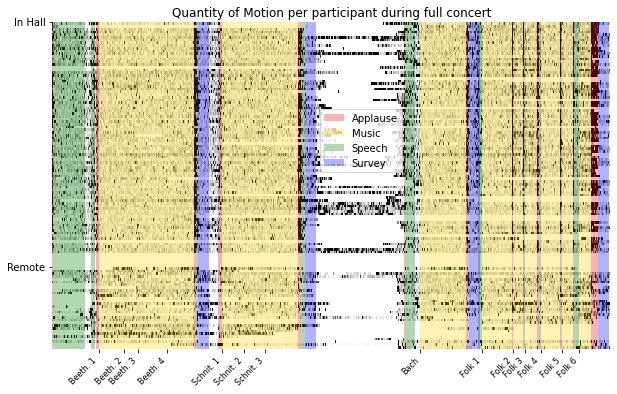

In [17]:
seg_start = concert_times.iloc[0,:].Time_s #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[51,:].Time_s + 200
print([seg_start,seg_end])
Event_Pallet={'Applause':'red','Music':'gold','Speech':'green','Survey':'blue','Synch':'purple'}
alpha_factor = 0.3

# seg_times = Main_concert_times.copy()
seg_df = AUD.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [10,6])
chart = sns.heatmap(data=-seg_df.transpose(), ax=ax1,vmin=-0.5, vmax=0,cbar=False, cmap=cm.gray)

seg_times = concert_times.loc[concert_times['Event_Type'].isin(['Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
plt.xticks(new_xticks,seg_times.Shorter_tag, fontsize=8, ha='right')
ax1.tick_params(axis='x', labelrotation=45)
seg_times = concert_times#.loc[concert_times['Event_Type'].isin(['Speech','Music'])]
new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end -seg_start)
new_dur = len(seg_df)*(seg_times['Event_Duration'])/(seg_end -seg_start)
new_dur_survey = len(seg_df)*(180)/(seg_end -seg_start)
xrange = [0,180]

ax1.margins(0)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='red',label="Applause",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1,  facecolor='gold',label="Music",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='green',label="Speech",alpha=alpha_factor)
ax1.axvspan(seg_start,xrange[0],0,1, facecolor='blue',label="Survey",alpha=alpha_factor)

ax1.legend(loc='upper left', bbox_to_anchor=(0.47,0.75))


alpha_factor = 0.3
yrange = [0,120.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = new_xticks[i]
    ej = new_xticks[i] + new_dur[i]
    if r['Event_Type'].startswith('Applause'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=alpha_factor)
    if r['Event_Type'].startswith('Musi'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='gold', alpha=alpha_factor)
    if r['Event_Type'].endswith('Speech'):
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=alpha_factor)
    if r['Event_Type'].startswith('Survey'):
        ej = new_xticks[i] + new_dur_survey
        ax1.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=alpha_factor)

ax1.set_yticks([0,90])
ax1.set_yticklabels(['In Hall','Remote'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./plots/qom_n_full_colour.png', bbox_inches = 'tight',dpi = 196)
plt.show()


# Scaling, segmentation and preliminary analysis
using 50 Hz sampled measurements.

In [18]:
aud_df.index = dt_ct        
ori_aud_df = aud_df.copy()
ori_aud_df.index = (ts_ct/1000).round(1)


In [19]:
ori_aud_df.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
-1086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1085.8,0.740777,0.467856,0.212834,0.101379,0.234912,0.224302,0.486310,0.064859,0.247404,0.237059,...,0.032345,NaN,NaN,NaN,NaN,0.227207,NaN,NaN,NaN,NaN
-1085.7,0.691307,0.179505,0.349901,0.100000,0.249657,0.184666,0.597926,0.055355,0.543207,0.371191,...,0.010653,NaN,NaN,NaN,NaN,0.183257,NaN,NaN,NaN,NaN
-1085.6,0.711500,0.137325,0.154668,0.063158,0.181522,0.134561,0.456580,0.072090,0.082915,1.156659,...,0.017225,NaN,NaN,NaN,NaN,0.140195,NaN,NaN,NaN,NaN


In [20]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
         sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()
df

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,BEQ113,BEQ114,BEQ115,BEQ116,BEQ117,BEQ118,BEQ119,BnQ131,BnQ132,BnQ133
Beethoven,0.069311,NaN,0.094418,0.101837,0.07339,0.108468,0.079436,0.086562,0.078947,0.132908,...,0.050851,0.209203,0.106644,0.164509,0.342741,0.182293,NaN,0.084129,0.272131,NaN
Schnittke,NaN,NaN,0.09243,0.143013,0.08211,0.1171,0.071236,0.08482,0.083305,0.106298,...,NaN,0.324734,0.160088,0.174884,0.288465,0.168656,NaN,NaN,0.142764,NaN
Bach,0.056344,0.135229,0.095909,0.124146,0.076237,0.103214,0.072805,0.075133,0.063821,0.103792,...,NaN,NaN,0.161927,NaN,NaN,NaN,0.041645,0.080859,0.044488,0.064046
Folk,0.090395,0.110848,0.12164,0.16044,0.102084,0.103741,0.122425,0.108638,0.077485,0.166454,...,0.13115,NaN,0.31208,1.033047,NaN,NaN,NaN,0.099888,0.068717,0.11593
Survey,0.209239,0.276741,0.138638,0.390651,0.154346,0.20982,0.193861,0.116464,0.160078,0.598902,...,2.63744,0.300593,NaN,0.21808,0.455517,NaN,NaN,0.257953,0.263718,0.225292
Speech,0.246232,0.292039,0.295855,0.372476,0.145761,0.229551,0.146598,0.182625,0.139083,0.437855,...,0.26774,0.461094,0.136921,0.538927,0.798314,0.263668,0.026651,0.132056,0.271759,0.362781
Clapping,0.938128,0.802796,1.06222,1.152516,0.567129,1.359547,1.303809,1.125798,0.856135,1.224338,...,0.235498,0.411525,0.168537,0.229127,0.441142,0.372743,0.443953,0.208247,0.400149,0.301939


In [21]:
mu = df.loc['Speech',df.columns.str.startswith('A')].median()
#scalling factor, just for simplicity of plotting. 
mu

0.19859234719686486

In [22]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk','Survey','Speech','Clapping']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
        if r['Event_Duration']> 45:
             sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    df.loc[ev_tag,:] = fullset.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
res1 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')

In [23]:
MTs = Main_concert_times.loc[Main_concert_times['Event_Type']=='Music',:]

ev_tags = MTs['Shorter_tag']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)

for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
print(results.index)
res2 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')

Index(['Beeth. 1', 'Beeth. 2', 'Beeth. 3', 'Beeth. 4', 'Schnit. 1',
       'Schnit. 2', 'Schnit. 3', 'Bach', 'Folk 1', 'Folk 2', 'Folk 3',
       'Folk 4', 'Folk 5', 'Folk 6'],
      dtype='object', name='Shorter_tag')


In [24]:
Ms = Main_concert_times.loc[Main_concert_times['Event_Duration']>30,:]
MTs = pd.concat([Ms.loc[Ms['Event_Type'].str.startswith('Survey'),:],
                 Ms.loc[Ms['Shorter_tag'].str.startswith('Speech MC'),:],
                 Ms.loc[Ms['Event'].str.startswith('Clapping for'),:]],axis=0)
MTs = MTs.loc[Ms['Event']!= 'Clapping for MC',:]
MTs['Shorter_tag'] = ['Survey 1', 'Survey 2', 'Survey 3',
       'Survey 4', 'Speech 1', 'Speech 2', 'Speech 3', 'Speech 4',
       'Speech 5', 'Applause 1','Applause 2','Applause 3']

ev_tags = MTs['Shorter_tag']
df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)

for i,r in MTs.iterrows():
    sigs=ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy()
    df.loc[r['Shorter_tag'],:] = sigs.mean()

# inhall only,scaled for plotting
results = df.loc[:,df.columns.str.startswith('A')].copy()/mu
print(results.index)
res3 = pd.melt(results.transpose(),var_name = 'Event',value_name ='Quantity of Movement (QoM)')

Index(['Survey 1', 'Survey 2', 'Survey 3', 'Survey 4', 'Speech 1', 'Speech 2',
       'Speech 3', 'Speech 4', 'Speech 5', 'Applause 1', 'Applause 2',
       'Applause 3'],
      dtype='object', name='Shorter_tag')


<ipython-input-25-81b516698115>:13: UserWarning: 
The palette list has fewer values (1) than needed (14) and will cycle, which may produce an uninterpretable plot.
  ax=sns.boxenplot(data=res2, x='Event', y='Quantity of Movement (QoM)', hue = 'Event', showfliers = True, palette=['gold'])


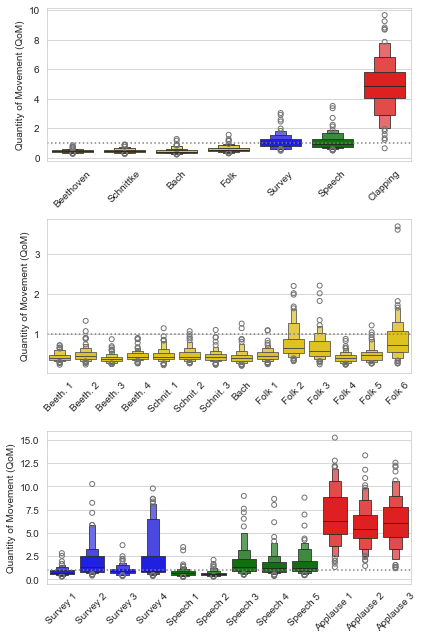

In [25]:
sns.set_style('whitegrid')
plt.figure(figsize=(6, 9)) #, dpi=90
 
event_palette = {'Beethoven':'gold', 'Schnittke':'gold', 'Bach':'gold', 'Folk':'gold', 
                 'Survey':'blue', 'Speech':'green','Clapping':'red'}
plt.subplot(3, 1, 1)
ax = sns.boxenplot(data=res1, x='Event', y='Quantity of Movement (QoM)', hue = 'Event',showfliers = True, palette=event_palette)
ax.set(xlabel=None)
plt.xticks(rotation=45)
plt.axhline(y=1, color='gray', linestyle=':')

plt.subplot(3, 1, 2)
ax=sns.boxenplot(data=res2, x='Event', y='Quantity of Movement (QoM)', hue = 'Event', showfliers = True, palette=['gold'])
ax.set(xlabel=None)
plt.xticks(rotation=45)
plt.axhline(y=1, color='gray', linestyle=':')

plt.subplot(3, 1, 3)
palette3 = ['blue','blue','blue','blue','green','green','green','green','green','red','red','red']
ax=sns.boxenplot(data=res3, x='Event', y='Quantity of Movement (QoM)', hue = 'Event', showfliers = True, palette=palette3)
ax.set(xlabel=None)
plt.xticks(rotation=45)
plt.axhline(y=1, color='gray', linestyle=':')
#
plt.tight_layout()
plt.savefig('plots/Figure_mix_qom',dpi = 196)

#
plt.show()

# Participant survey responses

Referenced results (demographics and traits) and specific tests and paper plots related to audience motion, performed and percieved.

In [100]:
# pull audience questionnair responses
Quest_text = pd.read_csv(public_Part + 'Surveys_Codebook.csv', delimiter=",", encoding='latin-1')
Quest_df = pd.read_csv(public_Part + 'Surveys_Prepared_Data_Public.csv',sep=',', encoding='latin-1')
Quest_df.set_index(Quest_df['ParticipantCode'],inplace = True,drop = True)
# only want the responses of people with aligned motion measurements
Quest_df = Quest_df.loc[aligned_Part_Codes,:].copy()#.reset_index(drop = True)
HQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('A'),:].copy()
RQ_df = Quest_df.loc[Quest_df['ParticipantCode'].str.startswith('B'),:].copy()
Quest_df.iloc[:5,:]

,ParticipantCode,age,gender,musician_status,personal_relation,fan,EC_1,EC_2,EC_3,EC_4,...,changed_behaviour,EC,EC_noTouched,AIMS,KM_Beethoven,KM_Schnittke,KM_Folk,AWE_Beethoven,AWE_Schnittke,AWE_Folk
ParticipantCode,,,,,,,,,,,,,,,,,,,,,
ADQ001,ADQ001,60.0,Woman,Music-loving nonmusician,No_Relation,7.0,4.0,3.0,3.0,2.0,...,NaN,3.714286,3.666667,144,3.6,3.5,4.3,3.833333,4.166667,3.833333
ADQ002,ADQ002,84.0,Man,Music-loving nonmusician,No_Relation,7.0,1.0,5.0,1.0,5.0,...,NaN,1.000000,1.000000,108,3.7,3.6,3.0,4.833333,4.833333,4.166667
ADQ003,ADQ003,46.0,Man,Music-loving nonmusician,No_Relation,7.0,5.0,1.0,4.0,1.0,...,NaN,4.428571,4.333333,127,1.4,1.3,2.9,1.000000,2.833333,1.833333
ADQ004,ADQ004,57.0,Man,Music-loving nonmusician,No_Relation,7.0,2.0,3.0,4.0,2.0,...,NaN,3.714286,3.500000,154,1.9,1.1,3.1,3.500000,4.333333,3.666667
ADQ005,ADQ005,47.0,Man,Serious amateur musician,Relative_Friend,7.0,2.0,3.0,3.0,4.0,...,NaN,2.428571,2.500000,117,1.2,2.8,3.6,3.000000,2.666667,3.500000


In [39]:
[len(HQ_df),len(RQ_df)]

[85, 30]

In [40]:
q = 1
Quest_text.loc[q,:]

ID                                         age
English_Q                    What is your age?
Danish_Q                    Hvad er din alder?
Response_Type                          integer
Data_Type                              integer
Response_Options_English    free text response
Response_Options_Danish                    NaN
Survey_Timing                      Pre-concert
Survey_Timing_Code                         1.0
Repeated_Question_Code                     NaN
Note                                       NaN
Reference                                  NaN
Name: 1, dtype: object

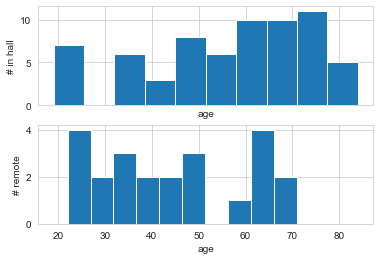

In [41]:
fig,(axes) = plt.subplots(2,1,sharex=True)
HQ_df[Quest_text.loc[q,'ID']].hist(ax=axes[0])
axes[0].set_xlabel(Quest_text.loc[q,'ID'])
axes[0].set_ylabel('# in hall')
RQ_df[Quest_text.loc[q,'ID']].hist(ax=axes[1])
axes[1].set_xlabel(Quest_text.loc[q,'ID'])
axes[1].set_ylabel('# remote')
plt.show()

In [42]:
q = 5
Quest_text.loc[q,:]

ID                                                                        fan
English_Q                   Are you a fan or admirer of the Danish String ...
Danish_Q                    Er du en fan eller beundrer af Den Danske Stry...
Response_Type                                                 multiple choice
Data_Type                                                             integer
Response_Options_English           1 (Neutral Listener) - 7 (Big Fan/Admirer)
Response_Options_Danish     1 (Beskriver mig ikke godt) - 5 (Beskriver mig...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                                      NaN
Reference                                                                 NaN
Name: 5, dtype: object

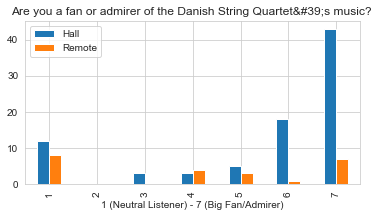

,Hall,Remote
7,0.511905,0.304348
6,0.726190,0.347826
5,0.785714,0.478261
4,0.821429,0.652174
3,0.857143,NaN
2,NaN,NaN
1,1.000000,1.000000


In [43]:
R_df = pd.DataFrame(index = range(1,8))
R_df['Hall'] = HQ_df[Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = RQ_df[Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar(figsize=(6, 3))
plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
# print(HQ_df[Quest_text.loc[q,'ID']].min())
# print(HQ_df[Quest_text.loc[q,'ID']].median())
# print(HQ_df[Quest_text.loc[q,'ID']].max())
# print(RQ_df[Quest_text.loc[q,'ID']].min())
# print(RQ_df[Quest_text.loc[q,'ID']].median())
# print(RQ_df[Quest_text.loc[q,'ID']].max())

R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

In [44]:
q = 4
Quest_text.loc[q,:]

ID                                                          personal_relation
English_Q                   What is your personal relationship to the Dani...
Danish_Q                    Hvad er din personlige relation til medlemmern...
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "I am a relative/friend, I dont have any part...
Response_Options_Danish     "Jeg er en ven/familie, Jeg har ikke nogen bes...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                                                                      NaN
Reference                                                                 NaN
Name: 4, dtype: object

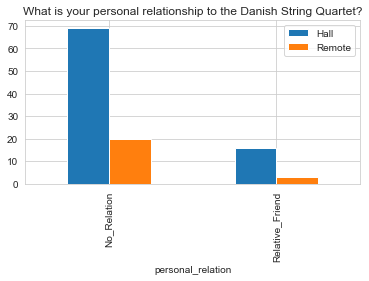

,Hall,Remote
personal_relation,,
No_Relation,0.811765,0.869565
Relative_Friend,0.188235,0.130435


In [45]:
R_df = pd.DataFrame()
R_df['Hall'] = HQ_df[Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = RQ_df[Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar(figsize=(6, 3))
# plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df

In [46]:
q = 3
Quest_text.loc[q,:]

ID                                                            musician_status
English_Q                                     Which title best describes you?
Danish_Q                            Hvilken beskrivelse passer bedst til dig?
Response_Type                                                 multiple choice
Data_Type                                                              string
Response_Options_English    "Tone-deaf, Nonmusician, Music-loving nonmusic...
Response_Options_Danish     "Tonedøv, Ikke-musiker, Musikelskende ikke-mus...
Survey_Timing                                                     Pre-concert
Survey_Timing_Code                                                        1.0
Repeated_Question_Code                                                    NaN
Note                        "A single item measure for identifying musicia...
Reference                                              Zhang & Schubert, 2019
Name: 3, dtype: object

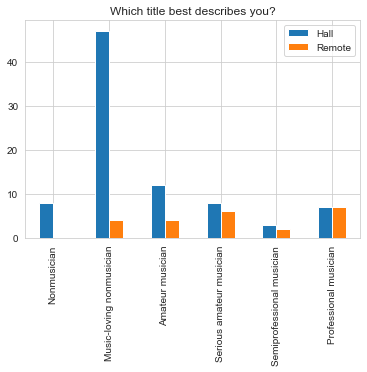

,Hall,Remote
Professional musician,0.082353,0.304348
Semiprofessional musician,0.117647,0.391304
Serious amateur musician,0.211765,0.652174
Amateur musician,0.352941,0.826087
Music-loving nonmusician,0.905882,1.000000
Nonmusician,1.000000,NaN


In [47]:
R_df = pd.DataFrame(index = ['Nonmusician','Music-loving nonmusician', 'Amateur musician', 
       'Serious amateur musician', 'Semiprofessional musician', 'Professional musician'])
R_df['Hall'] = HQ_df[Quest_text.loc[q,'ID']].value_counts()
R_df['Remote'] = RQ_df[Quest_text.loc[q,'ID']].value_counts()

R_df.plot.bar()
# plt.xlabel(Quest_text.loc[q,'Response_Options_English'])
plt.title(Quest_text.loc[q,'English_Q'])
plt.show()
R_df['Hall'] = R_df['Hall']/R_df['Hall'].sum()
R_df['Remote'] = R_df['Remote']/R_df['Remote'].sum()
R_df.iloc[::-1].cumsum()

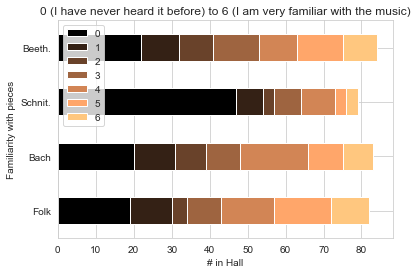

In [48]:
# Quest_df.iloc[:,[39,79,100,131]].hist(alpha = 0.55) 
R_df = pd.DataFrame(index = range(0,7),columns = ['Folk','Bach','Schnit.','Beeth.'])
R_df['Beeth.'] = HQ_df.iloc[:,39].value_counts()
R_df['Schnit.'] =  HQ_df.iloc[:,79].value_counts()
R_df['Bach'] =  HQ_df.iloc[:,100].value_counts()
R_df['Folk'] =  HQ_df.iloc[:,131].value_counts()
R_df.transpose().plot.barh(stacked=True,colormap='copper')
plt.ylabel('Familiarity with pieces')
plt.xlabel('# in Hall')
plt.title(Quest_text.loc[39,'Response_Options_English'])
plt.show()

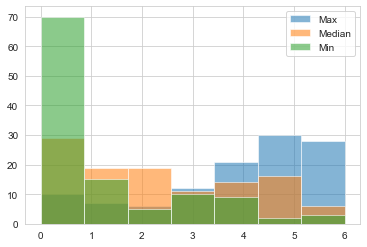

In [49]:
Quest_df.iloc[:,[39,79,100,131]].max(axis=1).hist(bins=7,alpha = 0.55,label='Max') 
Quest_df.iloc[:,[39,79,100,131]].median(axis=1).hist(bins=7,alpha = 0.55,label='Median')
Quest_df.iloc[:,[39,79,100,131]].min(axis=1).hist(bins=7,alpha = 0.55,label='Min')
plt.legend()   
plt.show()

# Motion ratings and QoM

In [50]:
sub_Q_List=['ParticipantCode',
            'aware_body_Beethoven', 'aware_movement_Beethoven', 'aware_others_moving_Beethoven',
            'aware_body_Schnittke', 'aware_movement_Schnittke', 'aware_others_moving_Schnittke',
            'aware_body_Bach', 'aware_movement_Bach', 'aware_others_moving_Bach', # bach
            'aware_body_Folk', 'aware_movement_Folk', 'aware_others_moving_Folk']

In [51]:
sub_text = Quest_text.loc[Quest_text['ID'].isin(sub_Q_List),:]
sub_text.set_index('ID',drop=True,inplace = True)
# sub_text

In [52]:
sub_Q = Quest_df[sub_Q_List].copy()
sub_H = HQ_df[sub_Q_List].copy()
sub_R = RQ_df[sub_Q_List].copy()

In [53]:
Full_Rels = pd.concat([Sub_Rels,Sub_Rels.rename(columns={'Participant_Code_1':'Participant_Code_2','Participant_Code_2':'Participant_Code_1'})])
# Full_Rels

In [54]:
ev_tags = ['Beethoven','Schnittke','Bach','Folk']
MQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
MSeenQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)
MaxSeenQoM_df = pd.DataFrame(index = ev_tags,columns = ori_aud_df.columns)

for ev_tag in ev_tags:
    MTs = Main_concert_times.loc[Main_concert_times['Event'].str.startswith(ev_tag),:]
    sigs = []
    for i,r in MTs.iterrows():
        if r['Event_Duration']> 45:
             sigs.append(ori_aud_df.loc[r['Time_s']:r['Time_s']+r['Event_Duration'],:].copy())
    fullset = pd.concat(sigs,axis=0)
    MQoM_df.loc[ev_tag,:] = fullset.mean()/mu
    for part in Full_Rels['Participant_Code_1'].unique():
        neighbours = Full_Rels.loc[Full_Rels['Participant_Code_1'].isin([part]),:]
        seen_neighbours = neighbours.loc[neighbours['Distance'].isin([1.0,2.0]),'Participant_Code_2'].values
        MSeenQoM_df.loc[ev_tag,part] = MQoM_df.loc[ev_tag,seen_neighbours].mean()
        MaxSeenQoM_df.loc[ev_tag,part] = MQoM_df.loc[ev_tag,seen_neighbours].max()  # max if helpful


In [55]:
# reQ
req_Q_List=['ParticipantCode','Music','Stimuli_N','aware_body', 'aware_movement', 'aware_others_moving']
sub_list = ['ParticipantCode','aware_body', 'aware_movement', 'aware_others_moving']
Stimuli_N = {1:'Beethoven',2:'Schnittke',3:'Bach',4:'Folk'}
 
# req_Q = pd.DataFrame(columns = req_Q_List)
mm_df = pd.DataFrame(columns=['ParticipantCode','Condition','Music','mQoM'])

for stim in Stimuli_N.keys():
    mtag= Stimuli_N[stim]
    A = sub_Q.loc[:,['ParticipantCode','aware_body_'+mtag, 'aware_movement_'+mtag, 'aware_others_moving_'+mtag]].copy()
    A=A.rename(columns={'aware_body_'+mtag:'aware_body', 'aware_movement_'+mtag:'aware_movement','aware_others_moving_'+mtag:'aware_others_moving'})
    A['Music'] = mtag
    A['Stimuli_N'] = stim
    A['mQoM']= MQoM_df.loc[mtag,:]
    A['Motion_seen']= MSeenQoM_df.loc[mtag,:]
    A['Motion_seen_Max']= MaxSeenQoM_df.loc[mtag,:] # max if helpful
    A.loc[A['ParticipantCode'].str.startswith('A'),'Condition'] = 'Hall'
    A.loc[A['ParticipantCode'].str.startswith('B'),'Condition'] = 'Remote'
    #req_Q = pd.concat([req_Q,A],axis=0)
    mm_df = pd.concat([mm_df,A])
    
# what are these stray values?? test with mm_df['aware_body'].hist()
# mm_df=mm_df.replace(['0','5'], np.nan)

mm_df

,ParticipantCode,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Stimuli_N,Motion_seen,Motion_seen_Max
ADQ001,ADQ001,Hall,Beethoven,0.349009,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,1.0,0.643888,0.723166
ADQ002,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,1.0,0.410694,0.464927
ADQ003,ADQ003,Hall,Beethoven,0.475438,Continuously,Yes and I moved a normal amount,Not aware of others' movement,1.0,0.526313,0.66925
ADQ004,ADQ004,Hall,Beethoven,0.512793,Not at all,Yes and I moved less than usual,Not aware of others' movement,1.0,0.48359,0.543642
ADQ005,ADQ005,Hall,Beethoven,0.36955,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,1.0,0.284358,0.284358
...,...,...,...,...,...,...,...,...,...,...
BEQ118,BEQ118,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
BEQ119,BEQ119,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
BnQ131,BnQ131,Remote,Folk,0.502979,Intermittently,Yes and I moved more than usual,Yes and they moved a normal amount,4.0,NaN,NaN
BnQ132,BnQ132,Remote,Folk,0.346021,Rarely,Not aware of movement,Not aware of others' movement,4.0,NaN,NaN


In [106]:
mm_df.to_csv('./data/Participants_Pieces_motion_judgements.csv',index=False)

In [107]:
mm_df = pd.read_csv('./data/Participants_Pieces_motion_judgements.csv')
mm_df

,ParticipantCode,Condition,Music,mQoM,aware_body,aware_movement,aware_others_moving,Stimuli_N,Motion_seen,Motion_seen_Max
0,ADQ001,Hall,Beethoven,0.349009,Intermittently,Yes and I moved less than usual,Yes and they moved less than usual,1.0,0.643888,0.723166
1,ADQ002,Hall,Beethoven,NaN,Rarely,Not aware of movement,Not aware of others' movement,1.0,0.410694,0.464927
2,ADQ003,Hall,Beethoven,0.475438,Continuously,Yes and I moved a normal amount,Not aware of others' movement,1.0,0.526313,0.669250
3,ADQ004,Hall,Beethoven,0.512793,Not at all,Yes and I moved less than usual,Not aware of others' movement,1.0,0.483590,0.543642
4,ADQ005,Hall,Beethoven,0.369550,Intermittently,Yes and I moved less than usual,Yes and they moved a normal amount,1.0,0.284358,0.284358
...,...,...,...,...,...,...,...,...,...,...
455,BEQ118,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
456,BEQ119,Remote,Folk,NaN,NaN,NaN,NaN,4.0,NaN,NaN
457,BnQ131,Remote,Folk,0.502979,Intermittently,Yes and I moved more than usual,Yes and they moved a normal amount,4.0,NaN,NaN
458,BnQ132,Remote,Folk,0.346021,Rarely,Not aware of movement,Not aware of others' movement,4.0,NaN,NaN


In [108]:
mm_df.columns

Index(['ParticipantCode', 'Condition', 'Music', 'mQoM', 'aware_body',
       'aware_movement', 'aware_others_moving', 'Stimuli_N', 'Motion_seen',
       'Motion_seen_Max'],
      dtype='object')

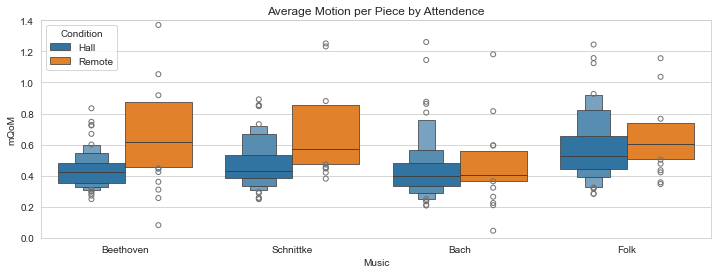

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Condition,2.936755,1,88,2.936755,20.409491,0.000019,NaN,0.188263,NaN,NaN,NaN,NaN
1,Music,1.262789,3,264,0.420930,9.031797,0.000010,0.000256,0.093081,0.674087,False,0.451046,1.114687e-13
2,Interaction,0.764813,3,264,0.254938,5.470140,0.001161,NaN,0.058523,NaN,NaN,NaN,NaN


In [109]:
tag_Q = 'Condition'
tag_m = 'mQoM'
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Hall','Virtual']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df, ax = ax1)
plt.xticks(fontsize=10)
plt.title('Average Motion per Piece by Attendence')
plt.ylim([0,1.4])
# plt.grid()
plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 196)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df)


In [110]:
mm_df_Hall = mm_df.loc[mm_df['Condition'].isin(['Hall']),:]
mm_df_Rem = mm_df.loc[mm_df['Condition'].isin(['Remote']),:]
# less 
mm_df_less = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk = mm_df_Hall.loc[mm_df_Hall['Music'].isin(['Folk']),:]
# less 
mm_df_less_R = mm_df_Rem.loc[mm_df_Rem['Music'].isin(['Beethoven','Schnittke','Bach']),:]
mm_df_Folk_R = mm_df_Rem.loc[mm_df_Rem['Music'].isin(['Folk']),:]

### Awareness of body

In [177]:
tag_Q = 'aware_body'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)

Were you aware of your physical body during this piece?


       Source  ddof1       ddof2         F     p-unc       np2
0  aware_body      3  100.357825  1.304347  0.277249  0.059193


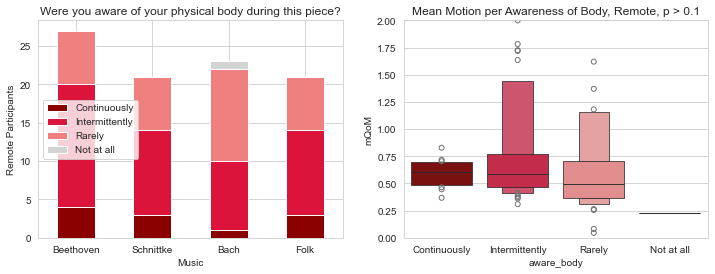

In [112]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_R[tag_Q + '_' + t].value_counts()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
# ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Remote Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Rem)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m,hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Rem, ax = ax2)
ax2.set_title('Mean Motion per Awareness of Body, Remote, p > 0.1')
ax2.set_ylim([0,2])
# ax2.grid()
plt.savefig('./plots/body_aware_B_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()

Were you aware of your physical body during this piece?
       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  83.779233  0.534294  0.660035  0.006529
                A               B   mean(A)   mean(B)      diff        se  \
0    Continuously  Intermittently  0.514049  0.473573  0.040475  0.034652   
1    Continuously      Not at all  0.514049  0.501173  0.012876  0.053960   
2    Continuously          Rarely  0.514049  0.477422  0.036626  0.038265   
3  Intermittently      Not at all  0.473573  0.501173 -0.027600  0.045007   
4  Intermittently          Rarely  0.473573  0.477422 -0.003849  0.024044   
5      Not at all          Rarely  0.501173  0.477422  0.023751  0.047844   

          T          df      pval    hedges  
0  1.168040   52.671390  0.649420  0.238394  
1  0.238618   57.447540  0.995166  0.057914  
2  0.957183   72.910315  0.774002  0.188620  
3 -0.613230   34.046676  0.927166 -0.159152  
4 -0.160076  142.683303  0.998533 -0.022834  
5  0

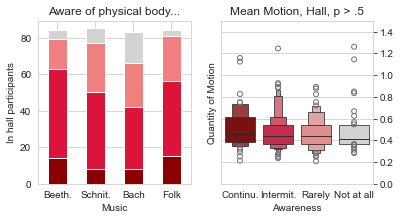

In [178]:
print(QuT)
QuT = 'Aware of physical body...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Continuously','Intermittently','Rarely','Not at all']
short_responses = ['Continu.','Intermit.','Rarely','Not at all']
resp_map = {'Continuously':'Continu.','Intermittently':'Intermit.','Rarely':'Rarely','Not at all':'Not at all'}

my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df.rename(columns=resp_map,inplace=True)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend=False,color = my_pal.values(),ax = ax1)
# ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(tracks_tag)
ax1.set_title(QuT)
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')
# fig.legend(loc='center right',ncol=3,fontsize = 8)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)
print(pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall))

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses)
# ax2.set_tickparam(axis='x',rotation='20')
ax2.set_xlabel('Awareness')
ax2.set_ylabel('Quantity of Motion')
ax2.set_title('Mean Motion, Hall, p > .5')
ax2.yaxis.tick_right()
ax2.set_ylim([0,1.5])
# ax2.grid()

plt.savefig('./plots/body_aware_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
#fig.legend(labels = feats, loc='center right', ncol=3,fontsize = 8)

plt.show()

In [115]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
sub_hist_df = pd.DataFrame(index = tracks, columns = sub_H[tag_Q + '_' + tracks[0]].unique())
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df

,Intermittently,Rarely,Continuously,Not at all,NaN
Beethoven,49.0,16.0,14.0,5.0,NaN
Schnittke,42.0,27.0,8.0,8.0,NaN
Bach,34.0,24.0,8.0,17.0,NaN
Folk,41.0,25.0,15.0,3.0,NaN


In [116]:
pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Continuously,Intermittently,0.514049,0.473573,0.040475,0.034652,1.168040,52.671390,0.649420,0.238394
1,Continuously,Not at all,0.514049,0.501173,0.012876,0.053960,0.238618,57.447540,0.995166,0.057914
2,Continuously,Rarely,0.514049,0.477422,0.036626,0.038265,0.957183,72.910315,0.774002,0.188620
3,Intermittently,Not at all,0.473573,0.501173,-0.027600,0.045007,-0.613230,34.046676,0.927166,-0.159152
4,Intermittently,Rarely,0.473573,0.477422,-0.003849,0.024044,-0.160076,142.683303,0.998533,-0.022834
5,Not at all,Rarely,0.501173,0.477422,0.023751,0.047844,0.496420,42.757365,0.959452,0.117673


       Source  ddof1      ddof2         F     p-unc       np2
0  aware_body      3  65.177414  0.514011  0.674063  0.015448
       Source  ddof1     ddof2         F     p-unc       np2
0  aware_body      3  9.222928  0.744481  0.551536  0.034897


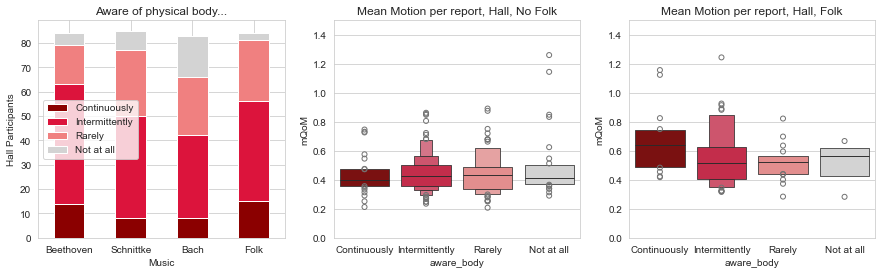

In [117]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Continuously','Intermittently','Rarely','Not at all']
my_pal = {'Continuously':'darkred','Intermittently':'crimson','Rarely':'lightcoral','Not at all':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="center left")
# ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue = tag_Q, legend=False,palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
ax2.set_title('Mean Motion per report, Hall, No Folk')
ax2.set_ylim([0,1.5])
# ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue = tag_Q, legend=False, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
ax3.set_title('Mean Motion per report, Hall, Folk')
ax3.set_ylim([0,1.5])
# ax3.grid()
plt.savefig('./plots/body_aware_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)
plt.show()

### Amount of motion, Normative

In [169]:
tag_Q = 'aware_movement'
tag_m = 'mQoM'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']
print(QuT)
QuT = 'Relative to your own usual behaviour...' 


Were you aware of your own physical movement during this piece? If so, how much did you move relative to your own usual behaviour at this kind of concert?


In [170]:
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.455071,3,8,0.151690,1.947278,0.200614,NaN,0.422042,NaN,NaN,NaN,NaN
1,Music,0.168243,3,24,0.056081,11.688065,0.000065,0.010944,0.593662,0.469263,False,0.14577,0.002292
2,Interaction,0.144259,9,24,0.016029,3.340612,0.008728,NaN,0.556094,NaN,NaN,NaN,NaN


In [171]:
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Rem)


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1006: RuntimeWarning: invalid value encountered in scalar divide
  msbetween = ssbetween / ddof1
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pingouin/parametric.py:1542: RuntimeWarning: divide by zero encountered in scalar divide
  ms_inter = ss_inter / df_inter


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,aware_movement,0.000000e+00,0,1,NaN,NaN,NaN,0.000000e+00,NaN
1,Music,4.111287e-02,3,3,0.013704,1.230545,0.434317,5.516791e-01,0.333333
2,Interaction,-2.775558e-17,0,3,-inf,-inf,NaN,-8.307494e-16,NaN


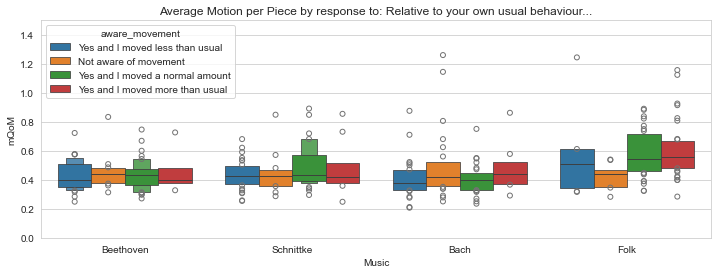

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_movement,0.455071,3,8,0.151690,1.947278,0.200614,NaN,0.422042,NaN,NaN,NaN,NaN
1,Music,0.168243,3,24,0.056081,11.688065,0.000065,0.010944,0.593662,0.469263,False,0.14577,0.002292
2,Interaction,0.144259,9,24,0.016029,3.340612,0.008728,NaN,0.556094,NaN,NaN,NaN,NaN


In [76]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}


f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
sns.boxenplot(x = 'Music',y = tag_m, hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(fontsize=10) #rotation='20',ha = 'right',
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
# plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv=tag_m,within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


In [77]:
hall_trimed = mm_df_Hall.loc[mm_df_Hall['mQoM'].notna(),:].copy()
rem_trimed = mm_df_Rem.loc[mm_df_Rem['mQoM'].notna(),:].copy()
X = hall_trimed.loc[:,'mQoM']
Y = rem_trimed.loc[:,'mQoM']
print([X.mean(),X.std()])
print([Y.mean(),Y.std()])
#https://vulstats.ucsd.edu/t-tests.html#summary-of-tests-for-the-mean-and-effect-sizes
s2x = am.sampVar(X)
s2y = am.sampVar(Y)
df = (((s2x/len(X))+(s2y/len(Y)))**2)/(((s2x**2)/((len(X)**2)*(len(X)-1)))+((s2y**2)/((len(Y)**2)*(len(Y)-1))))
print('degrees of freedom: ' + str(df))
sp.stats.ttest_ind(X,Y, equal_var=False)

[0.48171950223989796, 0.1803116248119169]
[0.7598664115151165, 0.6565562930397111]
degrees of freedom: 103.76368880682232


TtestResult(statistic=-4.18678134600176, pvalue=5.945923210183207e-05, df=103.76368880682232)

In [78]:
pg.ttest(X,Y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.186781,103.763689,two-sided,0.000059,"[-0.41, -0.15]",0.777996,485.122,0.999999


           Source  ddof1       ddof2         F     p-unc       np2
0  aware_movement      3  130.642006  4.747926  0.003552  0.046826


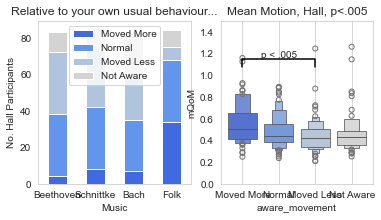

In [172]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['Moved More','Normal','Moved Less','Not Aware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1)
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('No. Hall Participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall) 
print(aov)
sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses)

ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:]
if len(a)>0:
    for i,row in a.iterrows():
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        am.barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)


ax2.set_title('Mean Motion, Hall, p<.005')
ax2.set_ylim([0,1.5])
ax2.grid()
plt.savefig('./plots/body_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


Relative to your own usual behaviour...
           Source  ddof1     ddof2         F     p-unc       np2
0  aware_movement      3  64.17205  1.147443  0.336795  0.017263
                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.478106   
1            Not aware of movement  Yes and I moved less than usual  0.478106   
2            Not aware of movement  Yes and I moved more than usual  0.478106   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.450000   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.450000   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.427522   

    mean(B)      diff        se         T          df      pval    hedges  
0  0.450000  0.028106  0.034667  0.810741   59.142804  0.849144  0.173956  
1  0.427522  0.050585  0.034561  1.463619   58.398000  0.465748  0.317927  
2  0.478021  0.000085  0.052817  0

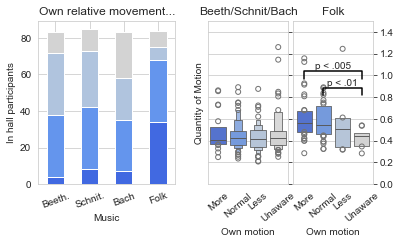

In [173]:
print(QuT)
QuT = 'Own relative movement...' 

tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']

response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
short_responses = ['More','Normal','Less','Unaware']
my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

fig = plt.figure(figsize=(6,3))
gridspec.GridSpec(1,4)

# large subplot
ax1 = plt.subplot2grid((1,12), (0,0), colspan=5, rowspan=1)

#f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),ax = ax1,legend=False)
#ax1.legend(loc="best")
# ax1.grid()
#ax1.tick_params(axis='x',labelrotation=0)
ax1.set_xticklabels(tracks_tag,rotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('In hall participants')
ax1.set_xlabel('Music')

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_less)
print(aov)
ax2 = plt.subplot2grid((1,12), (0,6), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_less, ax = ax2)
#ax2.set_title('Mean QoM, Hall, p>.3')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_less)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)     
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3], [1,1,1,1], yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)


ax2.set_ylim([0,1.5])
ax2.yaxis.tick_right()
ax2.set_yticklabels([])
ax2.set_ylabel('Quantity of Motion')

ax2.set_xlabel('Own motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=40)
ax2.set_title('Beeth/Schnit/Bach')
# ax2.grid()

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(aov)
ax3 = plt.subplot2grid((1,12), (0,9), colspan=3, rowspan=1)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Folk, ax = ax3)
#ax3.set_title('Mean QoM, Hall, p<.05')
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Folk)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.9-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(short_responses,rotation=40)
ax3.set_ylim([0,1.5])
ax3.set_ylabel('')
ax3.set_xlabel('Own motion')
ax3.yaxis.tick_right()
ax3.set_title('Folk')
# ax3.grid()
plt.savefig('./Plots/body_move_A_R_qom_less.png',bbox_inches = 'tight',dpi = 196)

plt.show()



In [174]:
sub_V = sub_Q.loc[sub_Q['ParticipantCode'].str.startswith('B'),:].copy()

           Source  ddof1      ddof2        F     p-unc       np2
0  aware_movement      3  32.732681  2.00647  0.132332  0.073698


<ipython-input-176-47b05f08d774>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(short_responses)
<ipython-input-176-47b05f08d774>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(short_responses,rotation=20)


                                 A                                B   mean(A)  \
0            Not aware of movement  Yes and I moved a normal amount  0.505818   
1            Not aware of movement  Yes and I moved less than usual  0.505818   
2            Not aware of movement  Yes and I moved more than usual  0.505818   
3  Yes and I moved a normal amount  Yes and I moved less than usual  0.672906   
4  Yes and I moved a normal amount  Yes and I moved more than usual  0.672906   
5  Yes and I moved less than usual  Yes and I moved more than usual  0.757349   

    mean(B)      diff        se         T         df      pval    hedges  
0  0.672906 -0.167088  0.117118 -1.426663  41.082583  0.490390 -0.352136  
1  0.757349 -0.251531  0.128619 -1.955631  35.929072  0.223722 -0.601589  
2  0.888360 -0.382542  0.184682 -2.071359  15.385060  0.205894 -0.855989  
3  0.757349 -0.084443  0.125495 -0.672877  47.900161  0.906826 -0.170378  
4  0.888360 -0.215454  0.182520 -1.180441  15.166461  0.6

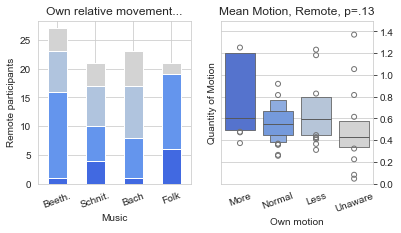

In [176]:
# tracks = ['Beethoven','Schnittke','Bach','Folk']
# response_order = ['Yes and I moved more than usual','Yes and I moved a normal amount','Yes and I moved less than usual','Not aware of movement']
# short_responses = ['Moved More','Normal','Moved Less','Not Aware']
# my_pal = {'Yes and I moved more than usual':'royalblue','Yes and I moved a normal amount':'cornflowerblue','Yes and I moved less than usual':'lightsteelblue','Not aware of movement':'lightgrey'}

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_V[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and I moved more than usual':'Moved More','Yes and I moved a normal amount':'Normal','Yes and I moved less than usual':'Moved Less','Not aware of movement':'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,legend = False, color = my_pal.values(),ax = ax1)
ax1.tick_params(axis='x',labelrotation=0)
ax1.set_title(QuT)
ax1.set_ylabel('Remote participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks_tag,rotation=20)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Rem) 
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m, hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Rem, ax = ax2)
ax2.set_xticklabels(short_responses)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Rem)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(0.75-0.07*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax2.set_xticklabels(short_responses,rotation=20)
ax2.yaxis.tick_right()
ax2.set_xlabel('Own motion')
ax2.set_ylabel('Quantity of Motion')
ax2.set_title('Mean Motion, Remote, p=.13')
ax2.set_ylim([0,1.5])
plt.savefig('./Plots/body_move_B_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()


## Amount of others' motion, normative

In [180]:
tag_Q = 'aware_others_moving'
tag_m = 'Motion_seen'
QuT = sub_text.loc[tag_Q + '_' + 'Folk','English_Q']
sub_text.loc[sub_text.index.str.startswith(tag_Q),'English_Q']

ID
aware_others_moving_Beethoven    Were you aware of others in the audience movin...
aware_others_moving_Schnittke    Were you aware of others in the audience movin...
aware_others_moving_Bach         Were you aware of others in the audience movin...
aware_others_moving_Folk         Were you aware of others in the audience movin...
Name: English_Q, dtype: object

In [181]:
print(QuT)
QuT = 'How were others moving...' 

Were you aware of others in the audience moving during the piece? If so, how much were they moving relative to the usual behaviour you observe at this kind of concert?


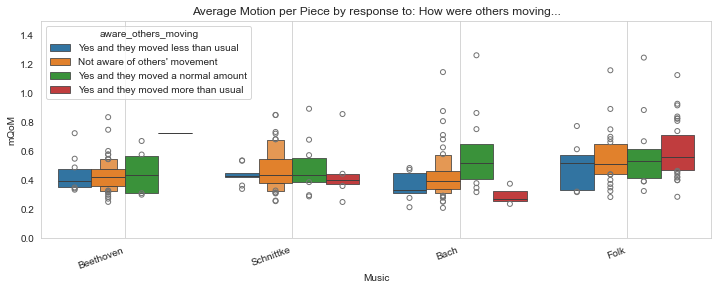

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,aware_others_moving,0.173092,2,21,0.086546,0.627469,0.543657,NaN,0.056389,NaN,NaN,NaN,NaN
1,Music,0.422788,3,63,0.140929,8.043824,0.000128,0.004555,0.276955,0.494,False,0.159264,1.635830e-07
2,Interaction,0.206756,6,63,0.034459,1.966833,0.083795,NaN,0.157765,NaN,NaN,NaN,NaN


In [152]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'Music',y = 'mQoM', hue = tag_Q,data = mm_df_Hall, ax = ax1)
plt.xticks(rotation=20,ha = 'right',fontsize=10)
plt.title('Average Motion per Piece by response to: ' + QuT)
plt.ylim([0,1.5])
plt.grid()
#plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = tag_Q,subject='ParticipantCode',data=mm_df_Hall)


In [164]:
sub_H[tag_Q + '_' + t].value_counts()

aware_others_moving_Folk
Yes and they moved more than usual    34
Not aware of others' movement         27
Yes and they moved a normal amount    15
Yes and they moved less than usual     7
Name: count, dtype: int64

                Source  ddof1      ddof2          F     p-unc       np2
0  aware_others_moving      3  89.567777  10.869167  0.000004  0.131509
                                    A                                   B  \
0       Not aware of others' movement  Yes and they moved a normal amount   
1       Not aware of others' movement  Yes and they moved less than usual   
2       Not aware of others' movement  Yes and they moved more than usual   
3  Yes and they moved a normal amount  Yes and they moved less than usual   
4  Yes and they moved a normal amount  Yes and they moved more than usual   
5  Yes and they moved less than usual  Yes and they moved more than usual   

    mean(A)   mean(B)      diff        se         T         df      pval  \
0  0.442797  0.477298 -0.034501  0.019471 -1.771935  59.887431  0.296823   
1  0.442797  0.438352  0.004445  0.015830  0.280814  58.810615  0.992191   
2  0.442797  0.558688 -0.115891  0.021079 -5.497972  55.032316  0.000006   
3  0.477298 

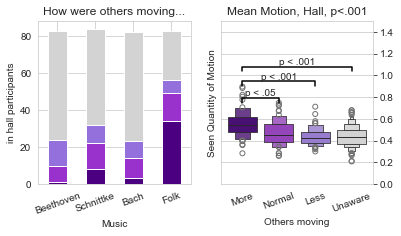

In [186]:
tracks = ['Beethoven','Schnittke','Bach','Folk']
tracks_tag = ['Beeth.','Schnit.','Bach','Folk']
response_order = ['Yes and they moved more than usual','Yes and they moved a normal amount','Yes and they moved less than usual',"Not aware of others' movement"]
my_pal = {'Yes and they moved more than usual':'indigo','Yes and they moved a normal amount':'darkorchid','Yes and they moved less than usual':'mediumpurple',"Not aware of others' movement":'lightgrey'}
short_responses = ['More','Normal','Less','Unaware']
tag_m = 'Motion_seen'

sub_hist_df = pd.DataFrame(index = tracks, columns = response_order)
for t in tracks:
    sub_hist_df.loc[t] = sub_H[tag_Q + '_' + t].value_counts()
sub_hist_df
sub_hist_df.rename(columns={'Yes and they moved more than usual':'Moved More','Yes and they moved a normal amount':'Normal','Yes and they moved less than usual':'Moved Less',"Not aware of others' movement":'Not Aware'},inplace=True)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

sub_hist_df.plot(kind='bar',stacked=True,color = my_pal.values(),legend=False,ax = ax1)
#ax1.legend()
# ax1.grid()
#ax1.tick_params(axis='x',labelrotation=20)
ax1.set_title(QuT)
#ax1.set_title('Hall Participants awareness of their own bodies')
ax1.set_ylabel('in hall participants')
ax1.set_xlabel('Music')
ax1.set_xticklabels(tracks,rotation=20)

aov = pg.welch_anova(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(aov)

sns.boxenplot(x = tag_Q,y = tag_m,hue=tag_Q,legend=False, palette=my_pal,order = response_order,data = mm_df_Hall, ax = ax2)
ac = pg.pairwise_gameshowell(dv=tag_m,between = tag_Q,data=mm_df_Hall)
print(ac)
ls = pd.Series(response_order)
a = ac.loc[ac.pval<0.001,:]
ac = ac.loc[ac.pval>=0.001,:].copy()
k = 0
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .001',[0,1,2,3],(1-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.005,:]
ac = ac.loc[ac.pval>=0.005,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .005',[0,1,2,3],(1-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.01,:]
ac = ac.loc[ac.pval>=0.01,:].copy()
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .01',[0,1,2,3],(1-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1
a = ac.loc[ac.pval<0.05,:]
if len(a)>0:
    for i,row in a.iterrows():
        barplot_annotate_brackets(ls.loc[ls==row['A']].index[0], ls.loc[ls==row['B']].index[0], 'p < .05',[0,1,2,3],(1-0.15*k)*np.array([1,1,1,1]), yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None)
        k+=1

ax2.set_ylabel('Seen Quantity of Motion')
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(short_responses,rotation=20)
ax2.yaxis.tick_right()
ax2.set_xlabel('Others moving')
ax2.set_title('Mean Motion, Hall, p<.001')
ax2.set_ylim([0,1.5])
# ax2.grid()
plt.savefig('./Plots/others_move_A_R_qom.png',bbox_inches = 'tight',dpi = 196)
plt.show()